# 1D WST Coefficients and Visualization

In [1]:
%matplotlib inline

import pylab as plt

import numpy as np
import pandas as pd

from blusky.transforms.apply_father_wavelet_1d import ApplyFatherWavlet1D
from blusky.transforms.cascade_tree import CascadeTree
from blusky.transforms.cascade_1d import Cascade1D
from blusky.transforms.default_decimation import (NoDecimation, 
                                                  DefaultDecimation)

# from blusky.transforms.i_decimation_method import IDecimationMethod
# from blusky.wavelets.i_wavelet_1d import IWavelet1D
from blusky.utils.pad_1d import Pad1D
from blusky.wavelets.wavelet_factories_1d import (vanilla_gabor_1d, 
                                                  vanilla_morlet_1d)
from keras.layers import Input
from keras import Model

from scipy.signal import resample


Using TensorFlow backend.


In this example use Gamma Ray well log measurements as the 1D signal.  Load the logs from the facies classification
[notebook]() and machine learning [contest]().

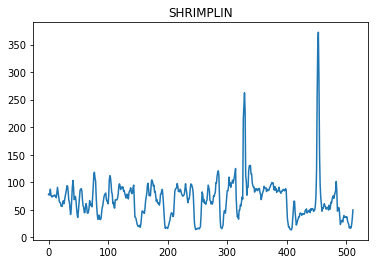

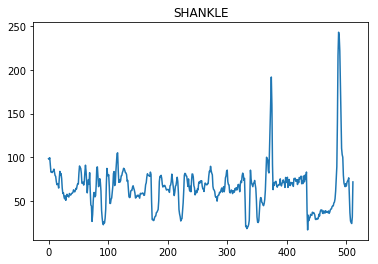

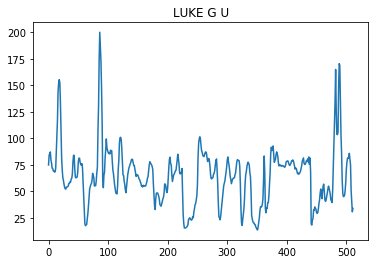

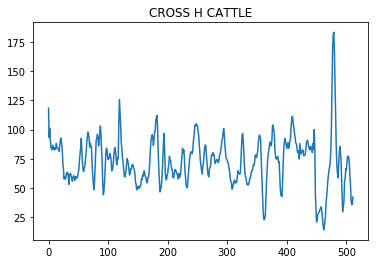

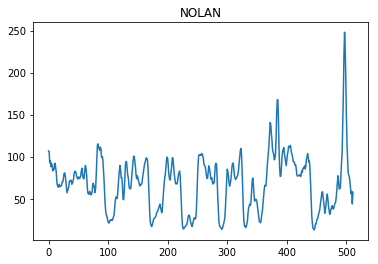

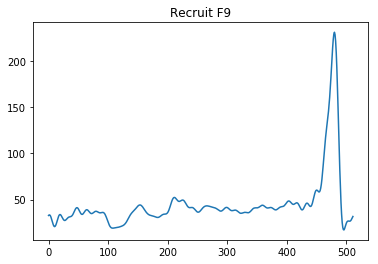

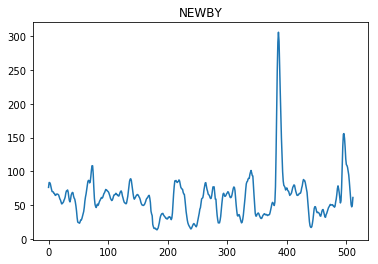

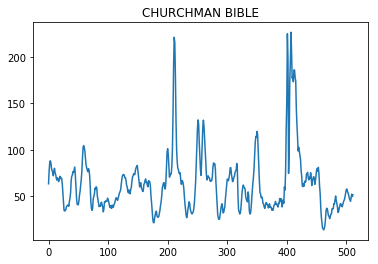

In [2]:
# resample wells to be power of 2 in length
N = 512

# store the logs in a dictionary, indexed by the well name.
logs = {} # raw logs
logs_norm = {} # normalized logs

df = pd.read_csv('training_data.csv')
well_names = df['Well Name'].unique()
for well_name in well_names:
    my_log = df[df['Well Name']==well_name]['GR'].values
    my_log = resample(my_log, N)
    logs[well_name] = my_log
    logs_norm[well_name] = logs[well_name]/np.sum(np.abs(logs[well_name]))
    plt.plot(logs[well_name])
    plt.title(well_name)
    plt.show()
    
del logs_norm['Recruit F9']

In [3]:
order = 2
sample_rate = 0.001

# for the father wavelet
# make this larger to remove the decimatoion
oversampling = 1
# if you want to stop decimation this needs to be "same"
father_padding = "valid"
# There's no need to change this:
conv_padding = "valid"

J = 7

# can j (resolution param) be exactly zero?
wavelets = [vanilla_morlet_1d(sample_rate, J, j) for j in range(1,J)]

# calibrate_wavelets_1d(wavelets)

father_wavelet = vanilla_gabor_1d(sample_rate, J)

deci = DefaultDecimation(oversampling=oversampling)
#deci = NoDecimation()

inp = Input(shape=(N,1))

# pad
pad_1d = Pad1D(wavelets, decimation=deci, conv_padding=conv_padding)
padded = pad_1d.pad(inp)

#
cascade_tree = CascadeTree(padded, order=order)

cascade = Cascade1D(decimation=deci, _padding=conv_padding)
convs = cascade.transform(cascade_tree, wavelets=wavelets)

# Create layers to remove padding
cascade_tree = CascadeTree(padded, order=order)
cascade_tree.generate(wavelets, pad_1d.unpad)
unpad = cascade_tree.get_convolutions()

# Remove the padding
unpadded_convs = [i[1](i[0]) for i in zip(convs, unpad)]

# the paper sets: fparam.J = Jmax-1
# 
appl = ApplyFatherWavlet1D(wavelet=father_wavelet, 
                           J=J, 
                           img_size=(N,), 
                           padding=father_padding,
                           sample_rate=sample_rate,
                           overlap_log_2=1)
sca_transf = appl.convolve(unpadded_convs)

# it's far more efficient to build the model once and reuse it:
model = Model(inputs=inp, outputs=sca_transf)

W1128 10:28:45.566553 4503678400 deprecation_wrapper.py:119] From /Users/bhall/.edm/envs/blusky/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1128 10:28:45.591770 4503678400 deprecation_wrapper.py:119] From /Users/bhall/.edm/envs/blusky/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1128 10:28:45.609728 4503678400 deprecation.py:323] From /Users/bhall/.edm/envs/blusky/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:2618: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


NotImplementedError: 

In [28]:
[vanilla_morlet_1d(sample_rate, J, j) for j in range(1,J)]

In [20]:

vanilla_morlet_1d(.001, 5, j=2)

TypeError: vanilla_morlet_1d() got multiple values for argument 'j'

In [ ]:
model.summary()

In [ ]:
ddelta = np.zeros(N)
ddelta[N//2] = 1
delta = model.predict(np.expand_dims(np.expand_dims(ddelta,axis=0), axis=-1))

In [8]:
_J = J
_N = range(len(delta))[::-1]

scale_order = []
counter = 0
for i,__order in enumerate(range(_J)[::-1]):
    scale_order.append(__order)
    for _i in range(i):
       scale_order.append(_N[counter])
       counter += 1

NameError: name 'delta' is not defined

In [9]:
def pseudo_dirac_norm(f, delta, scale_order):
    """ Not 100%, but normalizes each coefficient by the corresponding dirac
        delta coefficient, and resamples the vector on a interval proportional 
        to the relative power in the delta's "power" spectrum
    """
    #_f = np.squeeze([np.linalg.norm(f[i][0,:,0])/np.linalg.norm(delta[i][0,:,0]) for i in scale_order])
    #_dirac = np.squeeze([np.linalg.norm(delta[i][0,:,0])**2 for i in scale_order])
    #_f = np.squeeze([f[i][0,:,0]/delta[i][0,:,0] for i in scale_order])
    
    _f = np.hstack([f[i][0,:,0]/delta[i][0,:,0] for i in scale_order])
    
    #_dirac = np.squeeze([delta[i][0,:,0]**2 for i in scale_order])
    _dirac = np.hstack(np.array([delta[i][0,:,0]**2 for i in scale_order]))
    
    C = np.sum(_dirac)

    #_N = len(_dirac)*10
    _N = len(_dirac)
    step = np.int_(_N*_dirac/C)

    k0 = 1
    result = np.zeros(np.sum(step)+1)
    for i,k in enumerate(step):
        result[k0:k0+k] = _f[i]
        k0 += k
        
    return result

In [10]:
np.sum(logs_norm['SHANKLE'])

1.0

In [11]:
w1_res = model.predict(np.expand_dims(np.expand_dims(logs_norm['SHANKLE'],axis=0), axis=-1))
scat1 = pseudo_dirac_norm(w1_res, delta, scale_order)
# scat1[0] = np.sum(logs_norm['SHANKLE'])
wst = {}
for log in logs_norm.keys():
    wst[log] = 


SyntaxError: invalid syntax (<ipython-input-11-db18969c395e>, line 6)

In [12]:
f1_res = model.predict(np.expand_dims(np.expand_dims(f1,axis=0), axis=-1))
f2_res = model.predict(np.expand_dims(np.expand_dims(f2,axis=0), axis=-1))
f3_res = model.predict(np.expand_dims(np.expand_dims(f3,axis=0), axis=-1))
f4_res = model.predict(np.expand_dims(np.expand_dims(f4,axis=0), axis=-1))

scat1 = pseudo_dirac_norm(f1_res, delta, scale_order)
scat1[0] = np.sum(f1)
scat2 = pseudo_dirac_norm(f2_res, delta, scale_order)
scat2[0] = np.sum(f2)
scat3 = pseudo_dirac_norm(f3_res, delta, scale_order)
scat3[0] = np.sum(f3)
scat4 = pseudo_dirac_norm(f4_res, delta, scale_order)
scat4[0] = np.sum(f4)


NameError: name 'model' is not defined

In [10]:
(
 np.linalg.norm(scat2 - scat3)/(np.linalg.norm(scat2)*np.linalg.norm(scat3)), 
 np.linalg.norm(f2 - f3)/(np.linalg.norm(f2)*np.linalg.norm(f3)), 
 np.linalg.norm(fft(f2) - fft(f3))/(np.linalg.norm(fft(f2))*np.linalg.norm(fft(f3)))
)

(0.2381468959382847, 13.595714978950356, 0.42486609309219864)

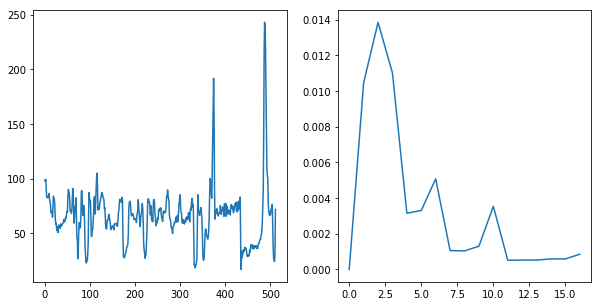

In [32]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(logs['SHANKLE'])
ax[1].plot(scat1)

(0, 65)

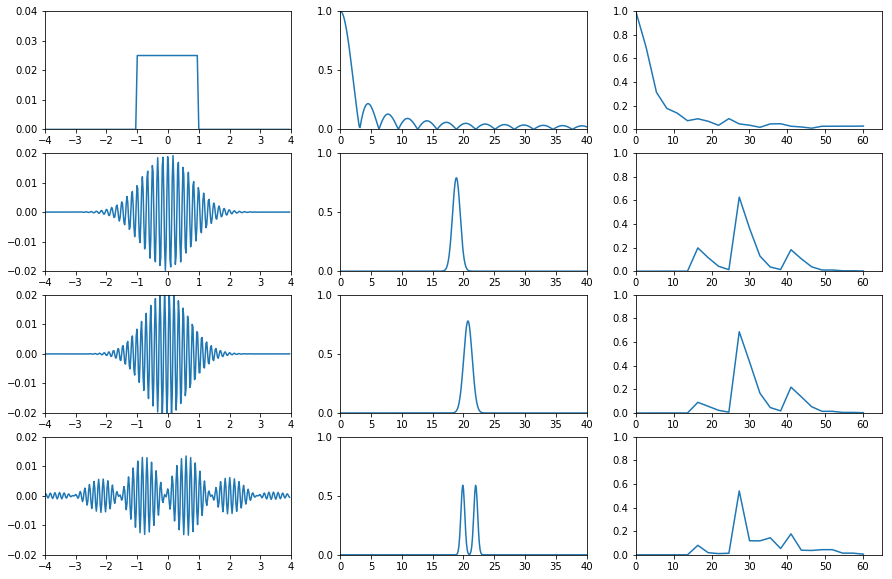

In [11]:
start_plot = np.int(N/2 - 4*R)
end_plot = np.int(N/2 + 4*R)

#domain for f1
num = f1[start_plot:end_plot].shape[0]
w = np.arange(1,num+1)
w = (w-1) * 8/num -4

# domain for f2 to f4
num = 16*R+1
w2 = np.arange(1,num)
w2 = (w2-1) * 8/num -4

# domain for fourier series
P = np.int(N/2)
z = np.arange(0,P)
z = 10*z*2*np.pi / P

# Why? get it!
#y = np.linspace(0,40,len(scat1))
y = 10*np.arange(len(scat1))*2*np.pi / len(scat1)

fig, ax = plt.subplots(4,3, figsize=(15,10))

ax[0,0].plot(w,f1[start_plot:end_plot])
ax[0,0].set_xlim((-4,4))
ax[0,0].set_ylim((0,0.04))
ax[0,1].plot(z,A1[0:np.int(N/2)])
ax[0,1].set_xlim((0,40))
ax[0,1].set_ylim((0,1))
ax[0,1].set_yticks([0, 0.5, 1])
ax[0,2].plot(y,scat1)
ax[0,2].set_ylim((0,1))
ax[0,2].set_xlim((0,65))

ax[1,0].plot(w2,f2[np.int(N/2 - 8*R):np.int(N/2 + 8*R)])
ax[1,0].set_xlim((-4,4))
ax[1,0].set_ylim((-0.02,.02))
ax[1,1].plot(z,A2[0:np.int(N/2)])
ax[1,1].set_xlim((0,40))
ax[1,1].set_ylim((0,1))
ax[1,1].set_yticks([0, 0.5, 1])
ax[1,2].plot(y,scat2)
ax[1,2].set_ylim((0,1))
ax[1,2].set_xlim((0,65))

ax[2,0].plot(w2,f3[np.int(N/2 - 8*R):np.int(N/2 + 8*R)])
ax[2,0].set_xlim((-4,4))
ax[2,0].set_ylim((-0.02,0.02))
ax[2,1].plot(z,A3[0:np.int(N/2)])
ax[2,1].set_xlim((0,40))
ax[2,1].set_ylim((0,1))
ax[2,1].set_yticks([0, 0.5, 1])
ax[2,2].plot(y,scat3)
ax[2,2].set_ylim((0,1))
ax[2,2].set_xlim((0,65))

ax[3,0].plot(w2,f4[np.int(N/2 - 8*R):np.int(N/2 + 8*R)])
ax[3,0].set_xlim((-4,4))
ax[3,0].set_ylim((-0.02,0.02))
ax[3,1].plot(z,A4[0:np.int(N/2)])
ax[3,1].set_xlim((0,40))
ax[3,1].set_ylim((0,1))
ax[3,1].set_yticks([0, 0.5, 1])
ax[3,2].plot(y,scat4)
ax[3,2].set_ylim((0,1))
ax[3,2].set_xlim((0,65))


## This is Figure 3 in the GIS paper:

<img src="GIS_figure3.png">

This is the MATLAB code to generate Figure 3 (above) in the GIS paper.

```python
% Reproduction of the Figure 3.2 of in the paper:
% “Group Invariant Scattering”, S. Mallat,
% Comm. in Pure and Applied Mathematics, Dec. 2012, Wiley
%
% Fourier transforms and scattering transforms of 4 different signals.

N = 8*1024; %signal size, power of two
Jmax = log2(N); %Maximum number of scales
%Choice of the wavelet
fparam.filter_type = {‘spline_1d’};
fparam.spline_order=3;
% Scale 2^J selected to display the scattering representation
fparam.J = Jmax-1;
fparam.Q = 1;
options.M = fparam.J;
Wop = wavelet_factory_1d(N, fparam, options);
% Examples of signals
%Indicator function of an interval
f1 = zeros(1,N);
R = 20;
  f1(N/2-R:N/2+R) = 1;
f1 = f1 ./sum(abs(f1));
f1=f1';
% Scattering transform
% tic
 Scat1 = diracNormScatt(f1,Wop);
% toc
P = length(Scat1);
y = zeros(1,P);
y(1:P) = (1:P);
y = 10 * y* 2 * pi/(P);
P = 8*R+1;
w = zeros(1,R);
w(1:P) = (1:P);
w = (w-1)*8/(P)-4;
figure(1);
hold off;
subplot(4,3,1), plot(w,f1(N/2-4*R:N/2+4*R));
%subplot(4,3,3), plotnormScatt(y,Scat1, Sdirac1, order1); %Scattered representation at the scale 2^J
subplot(4,3,3), plot(y,Scat1); %Scattered representation at the scale 2^J
% Modulus of the Fourier transform
A1 = abs(fft(f1));
P = N/2;
z = zeros(1,P);
z(1:P) = (1:P);
z =10 *  z* 2 * pi/(P);
subplot(4,3,2), plot(z,A1(1:N/2));
%plot(Scat1(:,J-1),‘g’);
hold off;
P = 16*R+1;
w = zeros(1,P);
w(1:P) = (1:P);
%w = w* 50(P);
w = (w-1)*8/(P)-4;
%First Gabor function
f1 = zeros(1,N);
R = 20;

  f1(1:N) = exp(-((1:N)-N/2).^2/(2 * (1024/32).^2)) .* cos(pi * (1:N)*0.90/3);
    
    
f1 = f1 ./sum(abs(f1));
f1=f1';
Scat1 = diracNormScatt(f1,Wop);
P = length(Scat1);
y = zeros(1,P);
y(1:P) = (1:P);
y = 10 * y* 2 * pi/(P);
hold off;
subplot(4,3,4), plot(w,f1(N/2-8*R:N/2+8*R));
subplot(4,3,6), plot(y,Scat1); %Scattered representation at the scale 2^J
A1 = abs(fft(f1));
P = N/2;
z = zeros(1,P);
z(1:P) = (1:P);
z = 10 * z* 2 * pi/(P);
subplot(4,3,5), plot(z,A1(1:N/2));
%plot(Scat1(:,J-1),‘g’);
hold off;
%Dilated Gabor Function
f2 = zeros(1,N);
R = 20;
  f2(1:N) = exp(-(1.1).^2*((1:N)-N/2).^2/(2 * (1024/32).^2)) .* cos(pi * (1:N)*1.1*0.9/3);
f2 = f2 ./sum(abs(f2));
f2=f2';
subplot(4,3,7), plot(w,f2(N/2-8*R:N/2+8*R));
Scat2 = diracNormScatt(f2,Wop);
%Scat2 = NormScatter(f2,wavelet_name,Jmax,‘White’);
%Scat = Scatter(f2,wavelet_name,Jmax,‘White’);
%figure(2);
hold off;
subplot(4,3,9),plot(y,Scat2); %Scattered representation at the scale 2^J
A2 = abs(fft(f2));
P = N/2;
z(1:P) = (1:P);
z = 10 * z* 2 * pi/(P);
subplot(4,3,8), plot(z,A2(1:N/2));
hold on;
%plot(Scat2(:,J-1),‘g’);
hold off;
%sum of a Gabor function and of a dilated Gabor function
f4 = zeros(1,N);
R = 20;
  f4(1:N) = exp(-((1:N)-N/2).^2/(2 * (1024/16).^2)) .* cos(pi * (1:N)*0.95/3) + exp(-((1:N)-N/2).^2/(2 * (1024/16).^2)) .* cos(pi * (1:N)*1/3*1.05) ;
f4 = f4 ./sum(abs(f4));
f4=f4';
Scat4 = diracNormScatt(f4,Wop);
P = length(Scat4);
y = zeros(1,P);
y(1:P) = (1:P);
y = 10 * y* 2 * pi/(P);
hold off;
subplot(4,3,10), plot(w,f4(N/2-8*R:N/2+8*R));
subplot(4,3,12), plot(y,Scat4); %Scattered representation at the scale 2^J
A4 = abs(fft(f4));
P = N/2;
z = zeros(1,P);
z(1:P) = (1:P);
z = 10 * z* 2 * pi/(P);
subplot(4,3,11), plot(z,A4(1:N/2));
%plot(Scat4(:,J-1),‘g’);
hold off;
fprintf(‘Left graphs: each row gives an example of function fi(x). \n Middle graphs: modulus of the Fourier transform of each fi \n as a function of the freRuency omega.\n Right graphs: normalized scattering transforms Sfi(R(omega))\n as a function of the freRuency omega.\n’);
```